### WBS Coding School
___
### --PROJECT--
# Supervised Machine Learning
### :: Regression: Housing prices

In this **Supervised Machine Learning** project I analyze a dataset of housing data and train machine learning algorithms to predict house prices.

It is a learning project, in which I practice advanced classification techniques such as feature selection, cross validation and pipelines consisting of preprocessing and modeling steps. I test a variety of models with different architectures to find the best performing ones.

The project is separated into 4 working notebooks:
- **01: Data Preparation and Exploration**
- *02: Baseline Model*
- *03: Feature Selection*
- *04: Model Training and Selection*

The dataset originates from an [indefinitely running Kaggle challenge](#https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/overview). A detailed description of the features can be found at the end of this notebook and stems from the `data_description.txt` file from Kaggle.
___

# Data Preparation and Exploration


___

## Table of contents:
- [1 Data Exploration](#exploration)
- [2 Data Cleaning](#cleaning)
- [3 Dataset Description](#description)
    - [3.1 Continuous Features](#continuous)
    - [3.2 Categorical Features](#categorical)

#### Import Libraries & Data

In [1]:
import pandas as pd
import seaborn as sns
from pathlib import Path

In [2]:
housing_data = pd.read_csv("data/train.csv")

The train.csv file contains the training data that include labels.

An exhaustive description of all the 80 features of the dataset can be found at the end of the notebook (section 3).

___
<a id="exploration"></a>
# 1&nbsp; Data Exploration

In this section, let's get a general feel for the dataset. We want to explore the shape of the data, get some insights into the labels (the `SalePrice` column), and the distribution of the numerical features.

In [3]:
housing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [4]:
housing_data_numerical = housing_data.select_dtypes(include="number")
housing_data_categorical = housing_data.select_dtypes(exclude="number")

print("Number of categorical columns:", housing_data_categorical.shape[1])
print("Number of numerical columns:  ", housing_data_numerical.shape[1])

Number of categorical columns: 43
Number of numerical columns:   38


Our data contains 1460 houses with 80 variables, i.e. features per house (1 of the 81 collumns is an ID column). Roughly half the features are categorical, the other half numerical. We can also already see in the .info() non-null count that there are many missing values that we'll need to deal with.

Next up, what do the house prices look like?

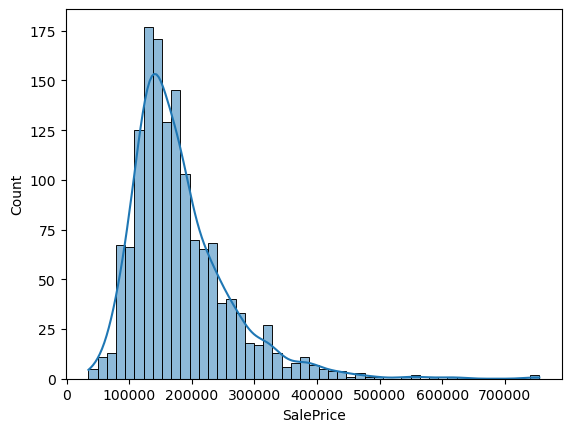

In [5]:
sns.histplot(data=housing_data, x="SalePrice", kde=True);

Most of the houses cost around 150k USD. As a European in the year 2023, I find that quite cheap.

Let's look at a couple of the important features in more detail.

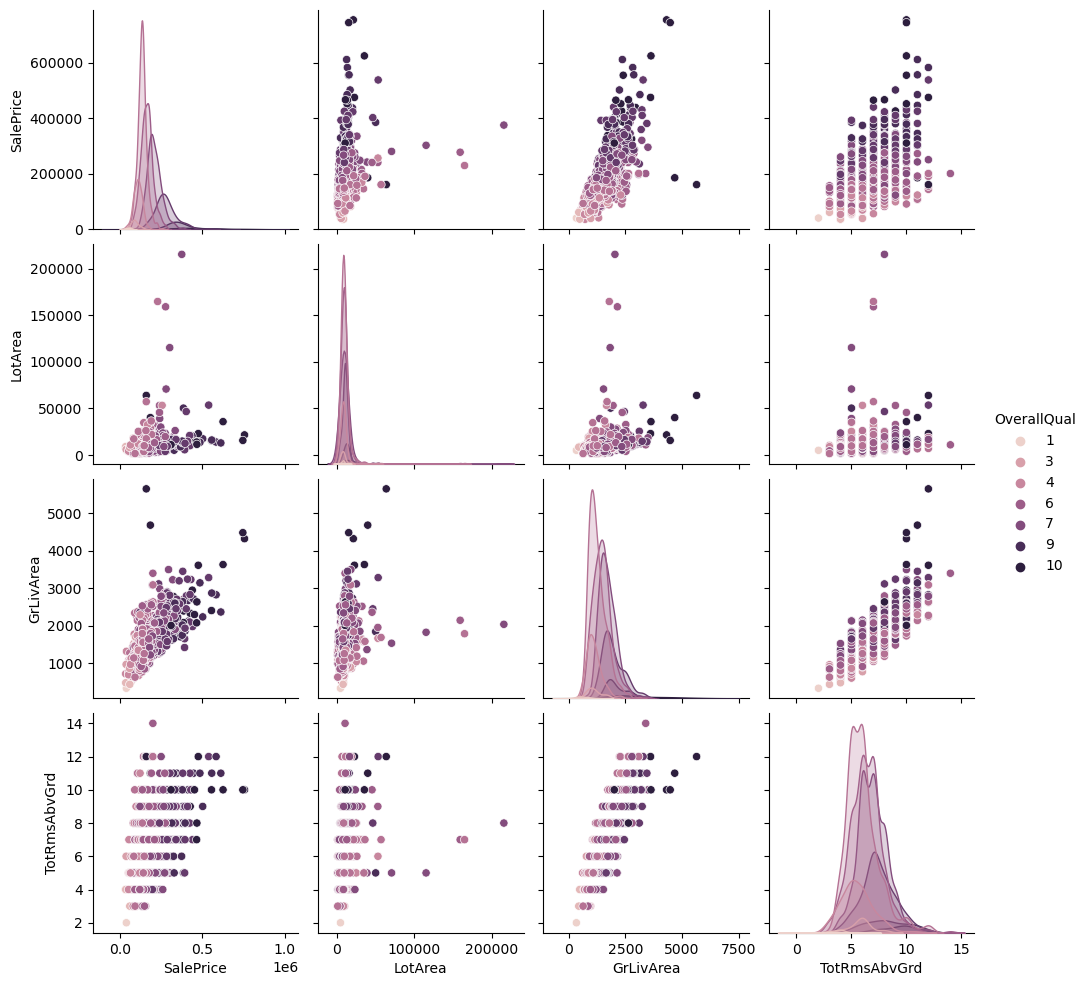

In [6]:
cols_to_plot = [
    'SalePrice',
    'LotArea', 
    'GrLivArea', 
    'TotRmsAbvGrd', 
    'OverallQual'
]

sns.pairplot(data=housing_data[cols_to_plot], hue="OverallQual");

The features `GrLivArea`, `TotRmsAbvGrd` and `OverallQual` seem to correlate quite well with house prices. Makes sense that overall living area, the number of rooms and the overall quality are important.

___
<a id="cleaning"></a>
# 2&nbsp; Data Cleaning

We already noticed an ID column that we don't need, as well as lots of missing values. There might also be duplicate rows. Let's tackle these issues here.

In [7]:
# Drop Id column
housing_data = housing_data.drop(columns="Id")

In [8]:
# Check for duplicates
print("Duplicate rows: ", housing_data.duplicated().sum())

Duplicate rows:  0


In [9]:
# Check for missing values
housing_data.isna().sum().nlargest(20)

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtExposure      38
BsmtFinType2      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
MasVnrType         8
MasVnrArea         8
Electrical         1
MSSubClass         0
dtype: int64

There are no duplicate columns, but there are loads of missing values in a total of 19 columns.

In the next step, we will look through these columns and see if their NA values need to be filled with something useful, or if we can just leave them as they are. Therefore, we'll look at the description of each column in the provided `data_description.txt` file (section 3 of this notebook).

##### Deal with Duplicates
Which features could have meaningful values instead of their NAs?

<pre>
LotFrontage   NA: 0
BsmtQual      NA: "No Basement"
BsmtCond      NA: "No Basement"
BsmtExposure  NA: "No Basement"
BsmtFinType1  NA: "No Basement"
FireplaceQu   NA: "No Fireplace"
MasVnrArea    NA: 0
GarageYrBlt   NA: "No Garage"
Alley         NA: "No alley access"
MasVnrType    NA: "None"
BsmtFinType2  NA: "No Basement"
Electrical    NA: "SBrkr"
GarageType    NA: "No Garage"
GarageFinish  NA: "No Garage"
GarageQual    NA: "No Garage"
GarageCond    NA: "No Garage"
PoolQC        NA: "No Pool"
Fence         NA: "No Fence"
MiscFeature   NA: "None"
</pre>

Indeed, most of these NAs have a meaning. Most often, the item is simply not available, e.g. a Garage, Basement, Pool or Fence. What we'll do for these ordinal categories is to simply add an "NA" category in the preprocessing pipeline in the next notebook (02_Baseline_Model). The only categorical column we'll want to change here is the `Electrical` column. This one has only one NA value, therefore we'll just fill that one with the most common electrical system: Standard Circuit Breakers & Romex (`SBrkr`).

We'll also need to take care of the numerical columns with missing values. These include `LotFrontage`, `MasVnrArea` and `GarageYrBlt`. Let's replace their values using median values from their `Neighborhood`.

In [10]:
# Replace missing values
housing_data["Electrical"].fillna("SBrkr", inplace=True)
housing_data["LotFrontage"] = housing_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))
housing_data["MasVnrArea"] = housing_data.groupby("Neighborhood")["MasVnrArea"].transform(lambda x: x.fillna(x.median()))
housing_data["GarageYrBlt"] = housing_data.groupby("Neighborhood")["GarageYrBlt"].transform(lambda x: x.fillna(x.median()))

##### Export Cleaned Data

In [11]:
# Create the directory if it doesn't already exist
Path("./data").mkdir(exist_ok=True)

housing_data.to_csv("data/train_clean.csv", index=False)

___
<a id="description"></a>
# 3&nbsp; Dataset Description

<a id="continuous"></a>
### 3.1&nbsp; Continuous Features

<pre>
LotFrontage:    Linear feet of street connected to property
LotArea:        Lot size in square feet

YearBuilt:      Original construction date
YearRemodAdd:   Remodel date (same as construction date if no remodeling or additions)

MasVnrArea:     Masonry veneer area in square feet

BsmtFinSF1:     Type 1 finished square feet
BsmtFinSF2:     Type 2 finished square feet
BsmtUnfSF:      Unfinished square feet of basement area
TotalBsmtSF:    Total square feet of basement area

1stFlrSF:       First Floor square feet
2ndFlrSF:       Second floor square feet

LowQualFinSF:   Low quality finished square feet (all floors)
GrLivArea:      Above grade (ground) living area square feet

BsmtFullBath:   Basement full bathrooms
BsmtHalfBath:   Basement half bathrooms

FullBath:       Full bathrooms above grade
HalfBath:       Half baths above grade
BedroomAbvGr:   Bedrooms above grade (does NOT include basement bedrooms)
KitchenAbvGr:   Kitchens above grade
TotRmsAbvGrd:   Total rooms above grade (does not include bathrooms)

Fireplaces:     Number of fireplaces	

GarageYrBlt:    Year garage was built
GarageCars:     Size of garage in car capacity
GarageArea:     Size of garage in square feet

WoodDeckSF:     Wood deck area in square feet

OpenPorchSF:    Open porch area in square feet
EnclosedPorch:  Enclosed porch area in square feet
3SsnPorch:      Three season porch area in square feet
ScreenPorch:    Screen porch area in square feet

PoolArea:       Pool area in square feet

MiscVal:        $Value of miscellaneous feature

MoSold:         Month Sold (MM)
YrSold:         Year Sold (YYYY)
</pre>

<a id="categorical"></a>
### 3.2&nbsp; Categorical Features

<pre>
MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

MSZoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM	Residential Medium Density

Street: Type of road access to property

       Grvl	Gravel	
       Pave	Paved
       	
Alley: Type of alley access to property

       Grvl	Gravel
       Pave	Paved
       NA 	No alley access
		
LotShape: General shape of property

       Reg	Regular	
       IR1	Slightly irregular
       IR2	Moderately Irregular
       IR3	Irregular
       
LandContour: Flatness of the property

       Lvl	Near Flat/Level	
       Bnk	Banked - Quick and significant rise from street grade to building
       HLS	Hillside - Significant slope from side to side
       Low	Depression
		
Utilities: Type of utilities available
		
       AllPub	All public Utilities (E,G,W,& S)	
       NoSewr	Electricity, Gas, and Water (Septic Tank)
       NoSeWa	Electricity and Gas Only
       ELO	Electricity only	
	
LotConfig: Lot configuration

       Inside	Inside lot
       Corner	Corner lot
       CulDSac	Cul-de-sac
       FR2	Frontage on 2 sides of property
       FR3	Frontage on 3 sides of property
	
LandSlope: Slope of property
		
       Gtl	Gentle slope
       Mod	Moderate Slope	
       Sev	Severe Slope
	
Neighborhood: Physical locations within Ames city limits

       Blmngtn	Bloomington Heights
       Blueste	Bluestem
       BrDale	Briardale
       BrkSide	Brookside
       ClearCr	Clear Creek
       CollgCr	College Creek
       Crawfor	Crawford
       Edwards	Edwards
       Gilbert	Gilbert
       IDOTRR	Iowa DOT and Rail Road
       MeadowV	Meadow Village
       Mitchel	Mitchell
       Names	North Ames
       NoRidge	Northridge
       NPkVill	Northpark Villa
       NridgHt	Northridge Heights
       NWAmes	Northwest Ames
       OldTown	Old Town
       SWISU	South & West of Iowa State University
       Sawyer	Sawyer
       SawyerW	Sawyer West
       Somerst	Somerset
       StoneBr	Stone Brook
       Timber	Timberland
       Veenker	Veenker
			
Condition1: Proximity to various conditions
	
       Artery	Adjacent to arterial street
       Feedr	Adjacent to feeder street	
       Norm	Normal	
       RRNn	Within 200' of North-South Railroad
       RRAn	Adjacent to North-South Railroad
       PosN	Near positive off-site feature--park, greenbelt, etc.
       PosA	Adjacent to postive off-site feature
       RRNe	Within 200' of East-West Railroad
       RRAe	Adjacent to East-West Railroad
	
Condition2: Proximity to various conditions (if more than one is present)
		
       Artery	Adjacent to arterial street
       Feedr	Adjacent to feeder street	
       Norm	Normal	
       RRNn	Within 200' of North-South Railroad
       RRAn	Adjacent to North-South Railroad
       PosN	Near positive off-site feature--park, greenbelt, etc.
       PosA	Adjacent to postive off-site feature
       RRNe	Within 200' of East-West Railroad
       RRAe	Adjacent to East-West Railroad
	
BldgType: Type of dwelling
		
       1Fam	Single-family Detached	
       2FmCon	Two-family Conversion; originally built as one-family dwelling
       Duplx	Duplex
       TwnhsE	Townhouse End Unit
       TwnhsI	Townhouse Inside Unit
	
HouseStyle: Style of dwelling
	
       1Story	One story
       1.5Fin	One and one-half story: 2nd level finished
       1.5Unf	One and one-half story: 2nd level unfinished
       2Story	Two story
       2.5Fin	Two and one-half story: 2nd level finished
       2.5Unf	Two and one-half story: 2nd level unfinished
       SFoyer	Split Foyer
       SLvl	Split Level
	
OverallQual: Rates the overall material and finish of the house

       10	Very Excellent
       9	Excellent
       8	Very Good
       7	Good
       6	Above Average
       5	Average
       4	Below Average
       3	Fair
       2	Poor
       1	Very Poor
	
OverallCond: Rates the overall condition of the house

       10	Very Excellent
       9	Excellent
       8	Very Good
       7	Good
       6	Above Average	
       5	Average
       4	Below Average	
       3	Fair
       2	Poor
       1	Very Poor

RoofStyle: Type of roof

       Flat	Flat
       Gable	Gable
       Gambrel	Gabrel (Barn)
       Hip	Hip
       Mansard	Mansard
       Shed	Shed
		
RoofMatl: Roof material

       ClyTile	Clay or Tile
       CompShg	Standard (Composite) Shingle
       Membran	Membrane
       Metal	Metal
       Roll	Roll
       Tar&Grv	Gravel & Tar
       WdShake	Wood Shakes
       WdShngl	Wood Shingles
		
Exterior1st: Exterior covering on house

       AsbShng	Asbestos Shingles
       AsphShn	Asphalt Shingles
       BrkComm	Brick Common
       BrkFace	Brick Face
       CBlock	Cinder Block
       CemntBd	Cement Board
       HdBoard	Hard Board
       ImStucc	Imitation Stucco
       MetalSd	Metal Siding
       Other	Other
       Plywood	Plywood
       PreCast	PreCast	
       Stone	Stone
       Stucco	Stucco
       VinylSd	Vinyl Siding
       Wd Sdng	Wood Siding
       WdShing	Wood Shingles
	
Exterior2nd: Exterior covering on house (if more than one material)

       AsbShng	Asbestos Shingles
       AsphShn	Asphalt Shingles
       BrkComm	Brick Common
       BrkFace	Brick Face
       CBlock	Cinder Block
       CemntBd	Cement Board
       HdBoard	Hard Board
       ImStucc	Imitation Stucco
       MetalSd	Metal Siding
       Other	Other
       Plywood	Plywood
       PreCast	PreCast
       Stone	Stone
       Stucco	Stucco
       VinylSd	Vinyl Siding
       Wd Sdng	Wood Siding
       WdShing	Wood Shingles
	
MasVnrType: Masonry veneer type

       BrkCmn	Brick Common
       BrkFace	Brick Face
       CBlock	Cinder Block
       None	None
       Stone	Stone

ExterQual: Evaluates the quality of the material on the exterior 
		
       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       Po	Poor
		
ExterCond: Evaluates the present condition of the material on the exterior
		
       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       Po	Poor
		
Foundation: Type of foundation
		
       BrkTil	Brick & Tile
       CBlock	Cinder Block
       PConc	Poured Contrete	
       Slab	Slab
       Stone	Stone
       Wood	Wood
		
BsmtQual: Evaluates the height of the basement

       Ex	Excellent (100+ inches)	
       Gd	Good (90-99 inches)
       TA	Typical (80-89 inches)
       Fa	Fair (70-79 inches)
       Po	Poor (< 70 inches)
       NA	No Basement
		
BsmtCond: Evaluates the general condition of the basement

       Ex	Excellent
       Gd	Good
       TA	Typical - slight dampness allowed
       Fa	Fair - dampness or some cracking or settling
       Po	Poor - Severe cracking, settling, or wetness
       NA	No Basement
	
BsmtExposure: Refers to walkout or garden level walls

       Gd	Good Exposure
       Av	Average Exposure (split levels or foyers typically score average or above)	
       Mn	Mimimum Exposure
       No	No Exposure
       NA	No Basement
	
BsmtFinType1: Rating of basement finished area

       GLQ	Good Living Quarters
       ALQ	Average Living Quarters
       BLQ	Below Average Living Quarters	
       Rec	Average Rec Room
       LwQ	Low Quality
       Unf	Unfinshed
       NA	No Basement

BsmtFinType2: Rating of basement finished area (if multiple types)

       GLQ	Good Living Quarters
       ALQ	Average Living Quarters
       BLQ	Below Average Living Quarters	
       Rec	Average Rec Room
       LwQ	Low Quality
       Unf	Unfinshed
       NA	No Basement

Heating: Type of heating
		
       Floor	Floor Furnace
       GasA	Gas forced warm air furnace
       GasW	Gas hot water or steam heat
       Grav	Gravity furnace	
       OthW	Hot water or steam heat other than gas
       Wall	Wall furnace
		
HeatingQC: Heating quality and condition

       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       Po	Poor
		
CentralAir: Central air conditioning

       N	No
       Y	Yes
		
Electrical: Electrical system

       SBrkr	Standard Circuit Breakers & Romex
       FuseA	Fuse Box over 60 AMP and all Romex wiring (Average)	
       FuseF	60 AMP Fuse Box and mostly Romex wiring (Fair)
       FuseP	60 AMP Fuse Box and mostly knob & tube wiring (poor)
       Mix	Mixed

KitchenQual: Kitchen quality

       Ex	Excellent
       Gd	Good
       TA	Typical/Average
       Fa	Fair
       Po	Poor

Functional: Home functionality (Assume typical unless deductions are warranted)

       Typ	Typical Functionality
       Min1	Minor Deductions 1
       Min2	Minor Deductions 2
       Mod	Moderate Deductions
       Maj1	Major Deductions 1
       Maj2	Major Deductions 2
       Sev	Severely Damaged
       Sal	Salvage only
		
FireplaceQu: Fireplace quality

       Ex	Excellent - Exceptional Masonry Fireplace
       Gd	Good - Masonry Fireplace in main level
       TA	Average - Prefabricated Fireplace in main living area or Masonry Fireplace in basement
       Fa	Fair - Prefabricated Fireplace in basement
       Po	Poor - Ben Franklin Stove
       NA	No Fireplace
		
GarageType: Garage location
		
       2Types	More than one type of garage
       Attchd	Attached to home
       Basment	Basement Garage
       BuiltIn	Built-In (Garage part of house - typically has room above garage)
       CarPort	Car Port
       Detchd	Detached from home
       NA	No Garage
				
GarageFinish: Interior finish of the garage

       Fin	Finished
       RFn	Rough Finished	
       Unf	Unfinished
       NA	No Garage

GarageQual: Garage quality

       Ex	Excellent
       Gd	Good
       TA	Typical/Average
       Fa	Fair
       Po	Poor
       NA	No Garage
		
GarageCond: Garage condition

       Ex	Excellent
       Gd	Good
       TA	Typical/Average
       Fa	Fair
       Po	Poor
       NA	No Garage
		
PavedDrive: Paved driveway

       Y	Paved 
       P	Partial Pavement
       N	Dirt/Gravel
		
PoolQC: Pool quality
		
       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       NA	No Pool
		
Fence: Fence quality
		
       GdPrv	Good Privacy
       MnPrv	Minimum Privacy
       GdWo	Good Wood
       MnWw	Minimum Wood/Wire
       NA	No Fence
	
MiscFeature: Miscellaneous feature not covered in other categories
		
       Elev	Elevator
       Gar2	2nd Garage (if not described in garage section)
       Othr	Other
       Shed	Shed (over 100 SF)
       TenC	Tennis Court
       NA	None

SaleType: Type of sale
		
       WD 	Warranty Deed - Conventional
       CWD	Warranty Deed - Cash
       VWD	Warranty Deed - VA Loan
       New	Home just constructed and sold
       COD	Court Officer Deed/Estate
       Con	Contract 15% Down payment regular terms
       ConLw	Contract Low Down payment and low interest
       ConLI	Contract Low Interest
       ConLD	Contract Low Down
       Oth	Other
		
SaleCondition: Condition of sale

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
</pre>